In [73]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [74]:
Nx = 101
x = np.linspace(-5,5,Nx, dtype = np.double)
dx = x[1] - x[0]
dx2 = dx**2

In [75]:
def numerov( sol, k2,S,Nx,dx):
    c = dx**2 /12 
    for i in range(1,Nx-1):
        sol[i+1] = (1/(1 + c * k2[i+1])) * (c * (S[i+1]+ 10*S[i] + S[i-1]) + 2*(1 - 5*c * k2[i])*sol[i] - (1+ c * k2[i-1])*sol[i-1]) 
    return sol

In [76]:
%%cython

cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport fabs
np.import_array()
@cython.boundscheck(False) #unstable, might cause random kernel crashes
@cython.wraparound(False)  # Same, probably 
def numerovf( double[:] sol , double[:] k2, double[:] S , int Nx, double dx):
    cdef int i
    cdef double c = (dx**2)/12
    for i in range(1,Nx-1):
        sol[i+1] = (1/(1 + c * k2[i+1])) * (c * (S[i+1]+ 10*S[i] + S[i-1]) + 2*(1 - 5*c * k2[i])*sol[i] - (1+ c * k2[i-1])*sol[i-1]) 
    return np.array(sol)

@cython.boundscheck(False) #unstable, might cause random kernel crashes
@cython.wraparound(False)  # Same, probably 
def numerovb( double[:] sol , double[:] k2, double[:] S , int Nx, double dx):
    cdef int i
    cdef double c = (dx**2)/12
    for i in range(Nx-2,0,-1):
        sol[i-1] = (1/(1 + c * k2[i-1])) * (c * (S[i+1]+ 10*S[i] + S[i-1]) + 2*(1 - 5*c * k2[i])*sol[i] - (1+ c * k2[i+1])*sol[i+1]) 
    return np.array(sol)

def secantc( double a, double b, func , double epsilon):
    cdef int count = 0
    cdef double f
    cdef double funca = func(a)
    cdef double funcb = func(b)
    cdef double c = (b*funca- a*funcb)/(funca - funcb)
    f = func(c)
    print(c,f)
    while( fabs(f) > epsilon):
        a = b
        b = c
        funca = func(a)
        funcb = f
        c = (b*funca- a*funcb)/(funca - funcb)
        f = func(c)
        count += 1
        print(c,f)
    print(count)
    return c

In [77]:
def secant( a, b, func , epsilon):
    count = 0
    funca = func(a)
    funcb = func(b)
    c = (b*funca- a*funcb)/(funca - funcb)
    f = func(c)
    #print(c,f)
    while( abs(f) > epsilon):
        a = b
        b = c
        funca = func(a)
        funcb = f
        c = (b*funca- a*funcb)/(funca - funcb)
        f = func(c)
        count += 1
        #print(c,f)
    #print(count)
    return c

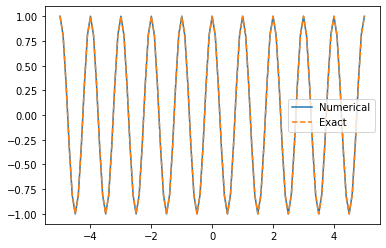

In [78]:
sol = np.ones(Nx, dtype = np.double)
sol[0] = 1
sol[1] = 1 - (dx**2 * 4 *np.pi**2) /2 + dx**4 * 2/3 * np.pi**4 # Calculated by hand using taylor series.
k2 = np.ones(Nx, dtype = np.double) * 4*np.pi**2
S = np.zeros(Nx, dtype = np.double)

solution =  numerovf(sol,k2,S,Nx,dx)
plt.plot(x,solution, label = 'Numerical')
plt.plot(x, np.cos(2*np.pi*x),'--', label = 'Exact')
plt.legend()
plt.show()

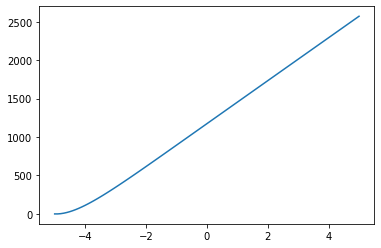

2572.2567619364986


In [79]:
k2 = np.zeros(Nx, dtype = np.double)
S = -x/2 * np.exp(-x)
sol1 = np.zeros(Nx, dtype = np.double)
sol1[0] = 0
sol1[1] = (1 - 0.5*(dx+2)*np.exp(-dx))*0.99
solution = numerovf(sol1,k2,S,Nx,dx)
plt.plot(x,solution)
plt.show()
print(solution[-1])

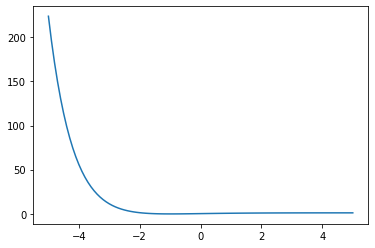

223.85432753661374


In [80]:
sol2 = np.zeros( Nx, dtype = np.double)
sol2[-1] = 1
sol2[-2] = 1
solution = numerovb(sol2,k2,S,Nx,dx)
plt.plot(x,solution)
plt.show()
print(solution[0])

0.5000000447141868


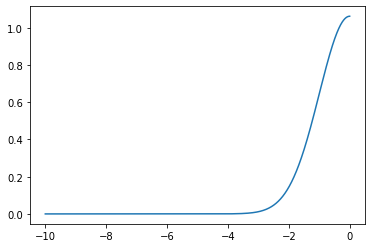

"\nef = np.concatenate((s,s[::-1]))\nef = norm(ef)\nX = np.concatenate((x,-x[::-1]))\nplt.plot(X,ef, label = 'numerical')\nplt.plot(X, (1/(np.pi**(1/4))) * np.exp(-X**2/2),'--', label = 'exact' )\nplt.legend()\nplt.show()\n"

In [105]:
Nx = 1000001
x = np.linspace(-10,0,Nx, dtype = np.double)
dx = x[1] - x[0]
dx2 = dx**2

def norm( array ):
    N = np.sqrt(dx*sum(array**2))
    return array / N
    
sol3 = np.zeros( Nx, dtype = np.double)
sol3[0] = 0
der = 1
sol3[1] = dx*der
V = 0.5*x**2

S = np.zeros( Nx, dtype = np.double)
k2 = np.ones( Nx, dtype = np.double)

def der( E ):
    solution = norm(numerovf(sol3,2*(E - V),S,Nx,dx))
    derivative = (solution[-3] - 4*solution[-2] + 3*solution[-1])/(2*dx)
    return derivative
def val( E ):
    solution = norm(numerovf(sol3,2*(E - V),S,Nx,dx))
    return solution[-1]

energy = secant(0,1,der,1e-6)
print(energy)
s = numerovf(sol3,2*(energy - V),S,Nx,dx)
plt.plot(x,norm(s))
plt.show()

'''
ef = np.concatenate((s,s[::-1]))
ef = norm(ef)
X = np.concatenate((x,-x[::-1]))
plt.plot(X,ef, label = 'numerical')
plt.plot(X, (1/(np.pi**(1/4))) * np.exp(-X**2/2),'--', label = 'exact' )
plt.legend()
plt.show()
'''

In [74]:
import numpy as np
import matplotlib.pyplot as plt

In [75]:
Nx = 10001
r = np.linspace(0,10,Nx)
h = r[1] - r[0]

def norm( array ):
    N = np.sqrt(h*np.sum(array**2))
    return array / N

def HF ( Z , epsilon ):
    energy = [0]
    k2 = np.zeros(Nx, dtype = np.double)   
    z = Z - 5/16
    R = 2*z**(3/2)*r*np.exp(-z*r)
    R = norm(R)
    diff = 1
    count = 0
    def value( e ):
        k2[1:] = 2*(Z/r[1:] - 0.5*phi[1:]/r[1:] +e)
        sol = numerovf(R,k2,np.zeros(Nx,dtype =np.double),Nx,h)
        return sol[-1]
    while abs(diff) > epsilon:
        phi = np.zeros(Nx)
        phi[-1] = 2
        phi[-2] = 2
        S = np.zeros(Nx)
        S[1:] = - R[1:]**2/r[1:]
        phi = numerovb(phi,np.zeros(Nx),S,Nx,h)
        E = (1/(h)) * np.sum( (R[1:] - R[:-1])**2 ) + 2*h*np.sum( (-Z/r[1:] + 0.25*phi[1:]/r[1:])*R[1:]**2 )
        energy.append(E)
        R = np.zeros(Nx, dtype = np.double)
        R[0] = 0
        R[1] = 1
        e = secant(-5,-4,value,1e-6)
        R = norm(R)
        diff = energy[-1] - energy[-2]
        count += 1
    plt.plot(r,R)
    plt.show()
    print(count)
    return R, energy

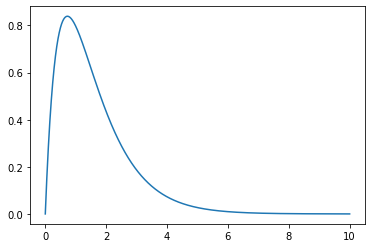

19


-2.4809558055109773

In [76]:
HF(2,1e-12)[1][-1]